# Test of the PyScatter treams extension

Aug. 2025

## Description   
This notebook shows how the treams scattering library (https://github.com/tfp-photonics/treams) can be extended to work with PyScatter beams. In particular, the treams illuminations can be modified to work with the focused LG beams defined in the focusedBeam class. This notebook loads functions for calculating the coefficients for the incident and scattered field of a focusedBeam incident on either one or more particles. It also applies functions for calculating cross-sections.

## Initialization

For a thorough guide to treams, the user is referred to the treams documentation: https://tfp-photonics.github.io/treams/index.html


Generally, all treams extension functions take the following inputs:
* A focusedBeam object (for obtaining the expansion coefficients)
* A treams "sphere" object or a list of "sphere" objects 
* A numpy array defining the position(s) of the sphere(s) 

The following sections of the notebook will demonstrate how to create these inputs for different situations

In [ ]:
import treams
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from src.focusedBeam import *
from src.domain import *
from src.interaction import *
from src.treams_functions import *

## Single particle test

In this section, the interaction between focused beams and centered, single particles is demonstrated using the treams software. These are simple cases that can be compared to the results of PyScatter

In [ ]:
# Define domain
dom = domain(size=2, points=100, planes={"xz"})  # 2 µm wide domain

# Define beam
wavelength = 0.632 # µm
k0 = 2 * np.pi / (wavelength * 1000)  # wavenumber in 1/nm
l = 2
maxJ = 15
NA = 0.9
p = 1 # helicity

# Define a focusedBeam object
LGbeam = focusedBeam(maxJ = maxJ, wl = wavelength, domain = dom, p = 1, l = l, NA = NA)

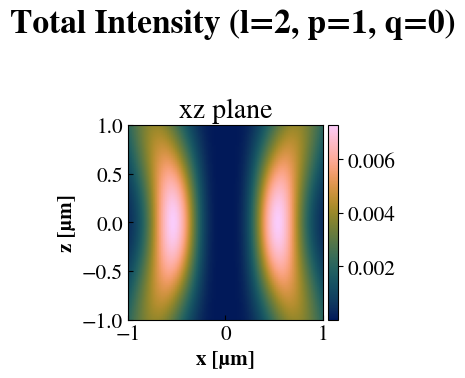

In [ ]:
# Plot the beam 
LGbeam.plot_beam(plot="total", globalnorm=False)

In [ ]:
# Define materials (spheres and outside) with permittivity
materials = [treams.Material(16 + 0.5j), treams.Material()]
print("refractive index: ", materials[0].n, "and ", materials[1].n)


# define the radius and positions of the dimer in nm
radius = 250

# Centered
position = np.array([
    [0, 0, 0],
], dtype=float)  # positions in nm

# Create a TMatrix for the sphere
sphere = treams.TMatrix.sphere(maxJ, k0, radius, materials)

refractive index:  (4.000488132314738+0.06249237386322317j) and  1.0
[[0. 0. 0.]]


### Fields

In [ ]:
# Calculate the coefficients and T-matrix for the focused beam interacting with the sphere
sca, beam, tm = focusedBeam_treams(LGbeam, sphere, position)

In [ ]:
# Define grid for field evaluation
x = np.linspace(-1000, 1000, 101)
y = 0
z = np.linspace(-1000, 1000, 101)
xx, zz = np.meshgrid(x, z, indexing="ij")
yy = np.full_like(xx, y)
grid = np.stack((xx, yy, zz), axis=-1)

In [ ]:
# Evaluate the total field (incident + scattered), scattered and incident fields at grid points

# scattered field
intensity_sca = np.zeros_like(xx)
valid = tm.valid_points(grid, [radius])
intensity_sca[~valid] = 0

# total intensity (scattered and incident)
intensity_tot = np.zeros_like(xx)
intensity_tot[~valid] = 0

# incident field
intensity_beam = np.zeros_like(xx)
intensity_beam[~valid] = 0

In [ ]:
# Extract fields
field_beam = beam.efield(grid[valid])
field_sca = sca.efield(grid[valid])

# Evaluate three intensities
intensity_sca[valid] = np.sum(np.abs(field_sca) ** 2, -1)
intensity_beam[valid] = np.sum(np.abs(field_beam) ** 2, -1)
intensity_tot[valid] = 0.5*np.sum(np.abs(field_beam + field_sca) ** 2, -1)

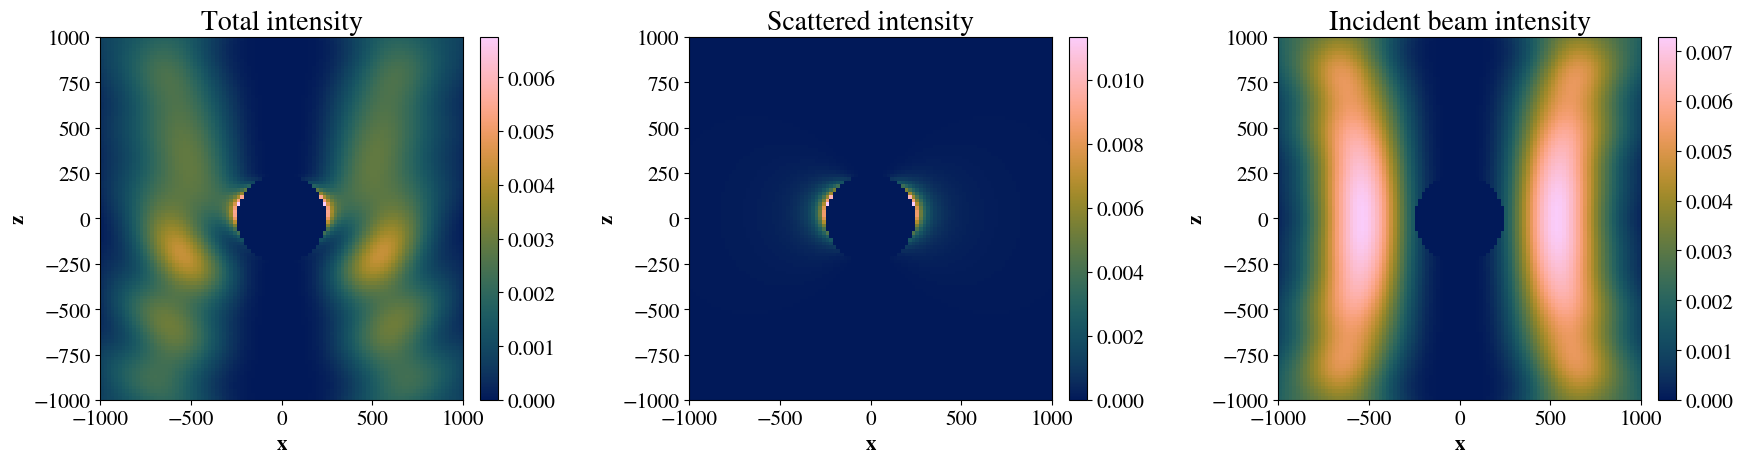

In [ ]:
# Plot the field intensities
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot total intensity
im0 = axes[0].imshow(intensity_tot.T, origin='lower', extent=[x.min(), x.max(), z.min(), z.max()],
                     cmap='cmc.batlow', vmin=np.nanmin(intensity_tot[valid]), vmax=np.nanmax(intensity_tot[valid]))
axes[0].set_title('Total intensity')
axes[0].set_xlabel('x')
axes[0].set_ylabel('z')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Plot scattered intensity
im1 = axes[1].imshow(intensity_sca.T, origin='lower', extent=[x.min(), x.max(), z.min(), z.max()],
                     cmap='cmc.batlow', vmin=np.nanmin(intensity_sca[valid]), vmax=np.nanmax(intensity_sca[valid]))
axes[1].set_title('Scattered intensity')
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Plot incident (beam) intensity
im2 = axes[2].imshow(intensity_beam.T, origin='lower', extent=[x.min(), x.max(), z.min(), z.max()],
                     cmap='cmc.batlow', vmin=np.nanmin(intensity_beam[valid]), vmax=np.nanmax(intensity_beam[valid]))
axes[2].set_title('Incident beam intensity')
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### Cross-sections

Using the 'focusedBeam_treams_xs' function, extract the scattering and extinction cross sections for an array of wavevector values. Note that the spheres object is created as a list for each k0.   
This takes some minutes to run

In [ ]:
k0s = 2 * np.pi * np.linspace(1 / 700, 1 / 300, 100)
spheres = [treams.TMatrix.sphere(maxJ, k0, radius, materials) for k0 in k0s]
xs_sca, xs_ext = focusedBeam_treams_xs(LGbeam, spheres, position)

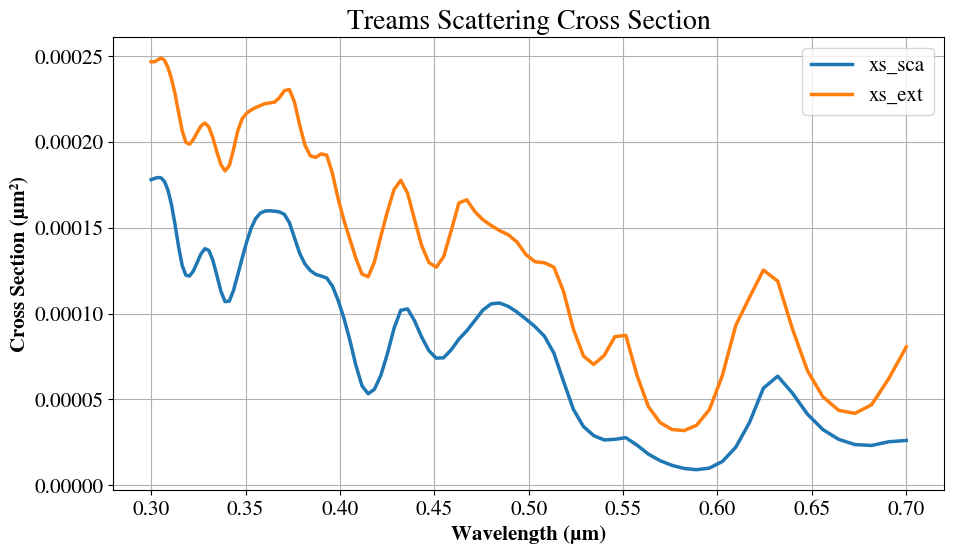

In [ ]:
wl_t = 1e-3 * 2*np.pi/k0s
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# First plot: Treams scattering cross section
ax.plot(wl_t, np.array(xs_sca)*1e-6, label='xs_sca')
ax.plot(wl_t, np.array(xs_ext)*1e-6, label='xs_ext')  # Uncomment if needed
ax.grid(True)
ax.set_xlabel('Wavelength (µm)')
ax.set_ylabel('Cross Section (µm²)')
ax.set_title('Treams Scattering Cross Section')
ax.legend()

plt.tight_layout()
plt.show()

To compare with PyScatter, create an interaction object using the same beam and refractive index:

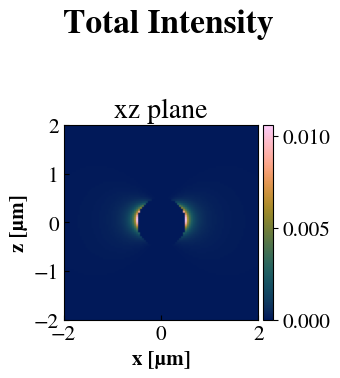

In [ ]:
inter = interaction(LGbeam, dom, materials[0].n, radius*1e-3, interaction="scattering")
inter.plot_int(plot="total")

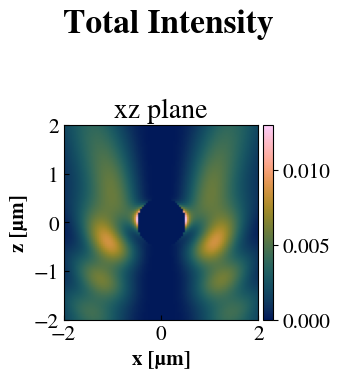

In [ ]:
inter = interaction(LGbeam, dom, materials[0].n, radius*1e-3, interaction="scattering")
inter.plot_int(plot="total", includeBeam = True)

-----Constant beam parameters-----

radius = 0.250  µm

nr = 4.000+0.062j 

-----------------------------------------

Calculating new size parameter array from radius and wavelength for 1D cross section with refractive index.

-----Constant beam parameters-----

radius = 0.250  µm

nr = 4.000+0.062j 

-----------------------------------------

Calculating new size parameter array from radius and wavelength for 1D cross section with refractive index.



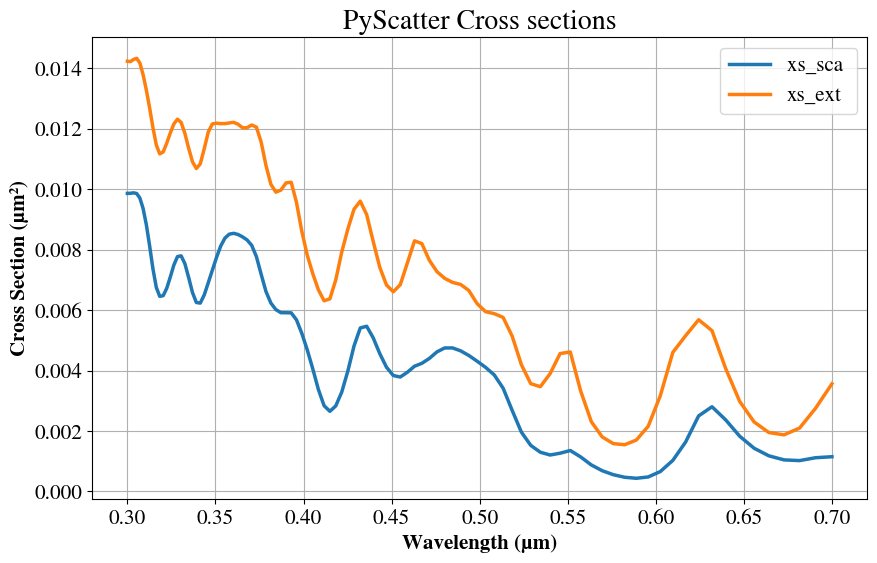

In [ ]:
wl = np.linspace(0.3, 0.7, 200)
Cscat = inter.getCrossSection(type="scattering", wavelength = wl_t, plot = False)
Cext = inter.getCrossSection(type="extinction", wavelength = wl_t, plot = False)
plt.figure(figsize=(10, 6))
plt.plot(wl_t, Cscat, label="xs_sca ")
plt.plot(wl_t, Cext, label="xs_ext")
plt.grid(True)
plt.xlabel("Wavelength (µm)")
plt.ylabel("Cross Section (µm²)")
plt.title("PyScatter Cross sections")
plt.legend()
plt.show()

## Dimer example

This examples demonstrates the interaction between a dimer and a focused Laguerre-Gaussian beam of order 1

In [ ]:
# Define domain
dom = domain(size=2, points=100, planes={"xz"})  # 2 µm wide domain

# Define beam
wavelength = 0.632 # µm
k0 = 2 * np.pi / (wavelength * 1000)  # wavenumber in 1/nm
l = 1
maxJ = 15
NA = 0.9
p = 1 # helicity

LGbeam = focusedBeam(maxJ = maxJ, wl = wavelength, domain = dom, p = 1, l = l, NA = NA)

### Verify beam parameters

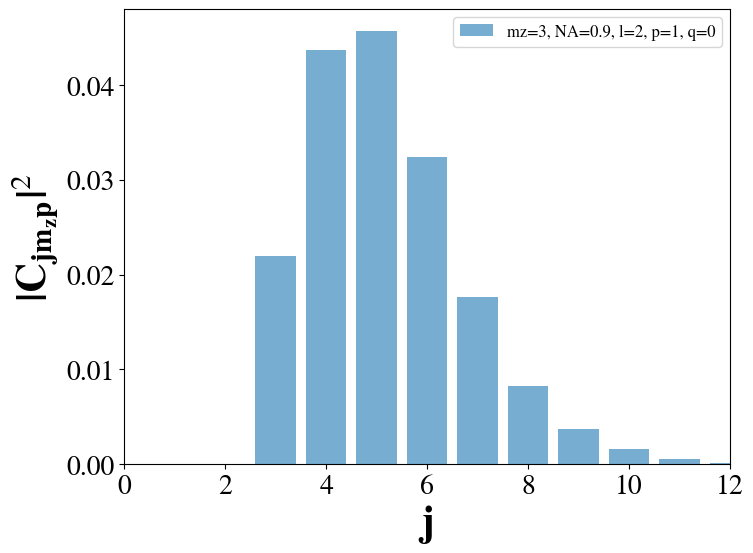

In [ ]:
# Plot beam coefficients to check that maxJ is sufficient
LGbeam.plot_Cjl()

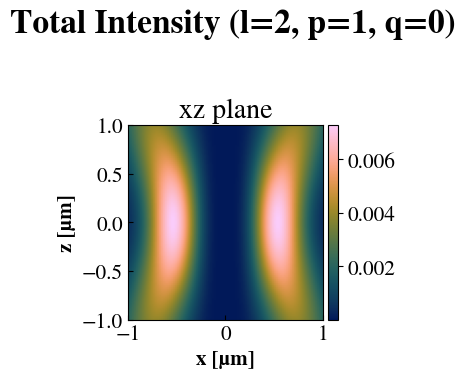

In [ ]:
# Plot beam 
LGbeam.plot_beam(plot="total")

### Dimer definition

In [ ]:
# Define materials (spheres and outside) with permittivity
materials = [treams.Material(16 + 0.5j), treams.Material()]
print("refractive index: ", materials[0].n, "and ", materials[1].n)


# define the radii and positions of the dimer in nm
radii = [200, 200]
positions = np.array([
    [-220, 0, 0],
    [220, 0, 0]
], dtype=float)  # positions in nm
# Create spheres with TMatrix (wl in nm)

spheres = [treams.TMatrix.sphere(maxJ, k0, r, materials) for r in radii]
print("Positions: ", positions)
print("Radii: ", radii)

refractive index:  (4.000488132314738+0.06249237386322317j) and  1.0
Positions:  [[-220.    0.    0.]
 [ 220.    0.    0.]]
Radii:  [200, 200]


### Fields

In [ ]:
# calculate the t-matrices
sca, beam, tm = focusedBeam_treams(LGbeam, spheres, positions)

/Users/joakimpugesgaardsandberg/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/5. år/Student Assistant-Nanomade/Scripts/Git/MieScat/treams/src/treams/util.py:159: AnnotationWarning: incompatible key 'basis'
  warnings.warn(f"incompatible key '{key}'", AnnotationWarning)


In [ ]:
# Create grid
x = np.linspace(-1000, 1000, 101)
y = 0
z = np.linspace(-1000, 1000, 101)
xx, zz = np.meshgrid(x, z, indexing="ij")
yy = np.full_like(xx, y)
grid = np.stack((xx, yy, zz), axis=-1)

In [ ]:
# Evaluate the total field (incident + scattered), scattered and incident fields at grid points

# scattered field
intensity_sca = np.zeros_like(xx)
valid = tm.valid_points(grid, radii)
intensity_sca[~valid] = 0

# total intensity (scattered and incident)
intensity_tot = np.zeros_like(xx)
intensity_tot[~valid] = 0

# incident field
intensity_beam = np.zeros_like(xx)
intensity_beam[~valid] = 0

In [ ]:
# Extract fields
field_beam = beam.efield(grid[valid])
field_sca = sca.efield(grid[valid])

In [ ]:
# Evaluate three intensities
intensity_sca[valid] = np.sum(np.abs(field_sca) ** 2, -1)
intensity_beam[valid] = np.sum(np.abs(field_beam) ** 2, -1)
intensity_tot[valid] = 0.5*np.sum(np.abs(field_beam + field_sca) ** 2, -1)

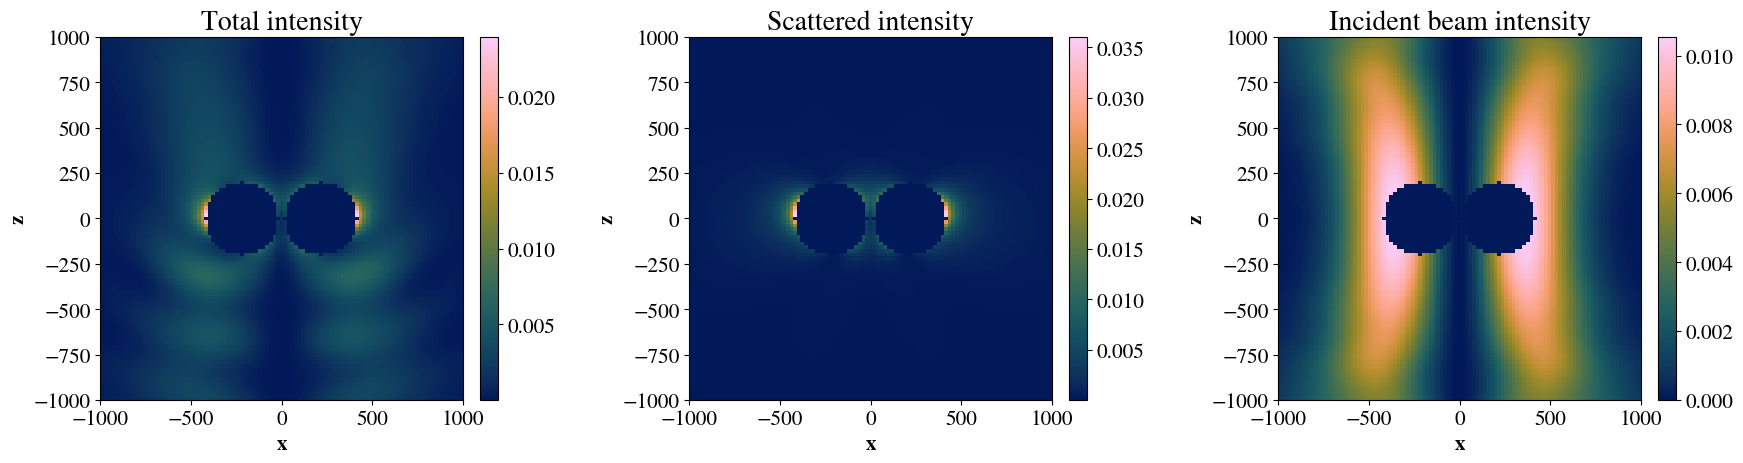

In [ ]:
# Plot the field intensities
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot total intensity
im0 = axes[0].imshow(intensity_tot.T, origin='lower', extent=[x.min(), x.max(), z.min(), z.max()],
                     cmap='cmc.batlow', vmin=np.nanmin(intensity_tot[valid]), vmax=np.nanmax(intensity_tot[valid]))
axes[0].set_title('Total intensity')
axes[0].set_xlabel('x')
axes[0].set_ylabel('z')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Plot scattered intensity
im1 = axes[1].imshow(intensity_sca.T, origin='lower', extent=[x.min(), x.max(), z.min(), z.max()],
                     cmap='cmc.batlow', vmin=np.nanmin(intensity_sca[valid]), vmax=np.nanmax(intensity_sca[valid]))
axes[1].set_title('Scattered intensity')
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Plot incident (beam) intensity
im2 = axes[2].imshow(intensity_beam.T, origin='lower', extent=[x.min(), x.max(), z.min(), z.max()],
                     cmap='cmc.batlow', vmin=np.nanmin(intensity_beam[valid]), vmax=np.nanmax(intensity_beam[valid]))
axes[2].set_title('Incident beam intensity')
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Some field confinement between the particles is seen, along with a higher intensity on the outsides, where the beam also excites with a higher intensity.

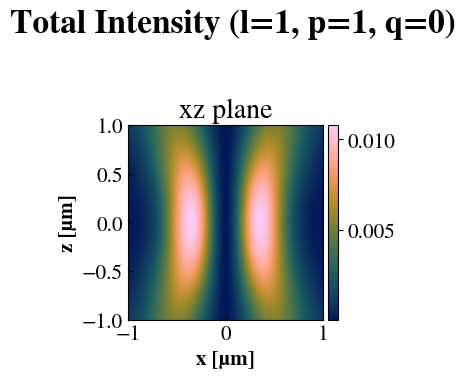

In [ ]:
#compare with beam plot

LGbeam.plot_beam(plot="total", globalnorm=False)

### Cross sections   
Use the final available function to extract the scattering and extinction cross sections for a variety of wavelengths. This is a slow method due to the parameter space

In [ ]:
k0s = 2 * np.pi * np.linspace(1 / 700, 1 / 300, 20)

In [ ]:
sca, ext = focusedBeam_treams_xs_cluster(LGbeam, spheres, positions, k0s)

/Users/joakimpugesgaardsandberg/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/5. år/Student Assistant-Nanomade/Scripts/Git/MieScat/treams/src/treams/util.py:111: AnnotationWarning: overwriting key 'k0'
  warnings.warn(f"overwriting key '{key}'", AnnotationWarning)
/Users/joakimpugesgaardsandberg/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/5. år/Student Assistant-Nanomade/Scripts/Git/MieScat/treams/src/treams/util.py:111: AnnotationWarning: overwriting key 'k0'
  warnings.warn(f"overwriting key '{key}'", AnnotationWarning)
/Users/joakimpugesgaardsandberg/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/5. år/Student Assistant-Nanomade/Scripts/Git/MieScat/treams/src/treams/util.py:111: AnnotationWarning: overwriting key 'k0'
  warnings.warn(f"overwriting key '{key}'", AnnotationWarning)
/Users/joakimpugesgaardsandberg/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/5. år/Student Assistant-Nanomade/Scripts/Git/MieScat/treams

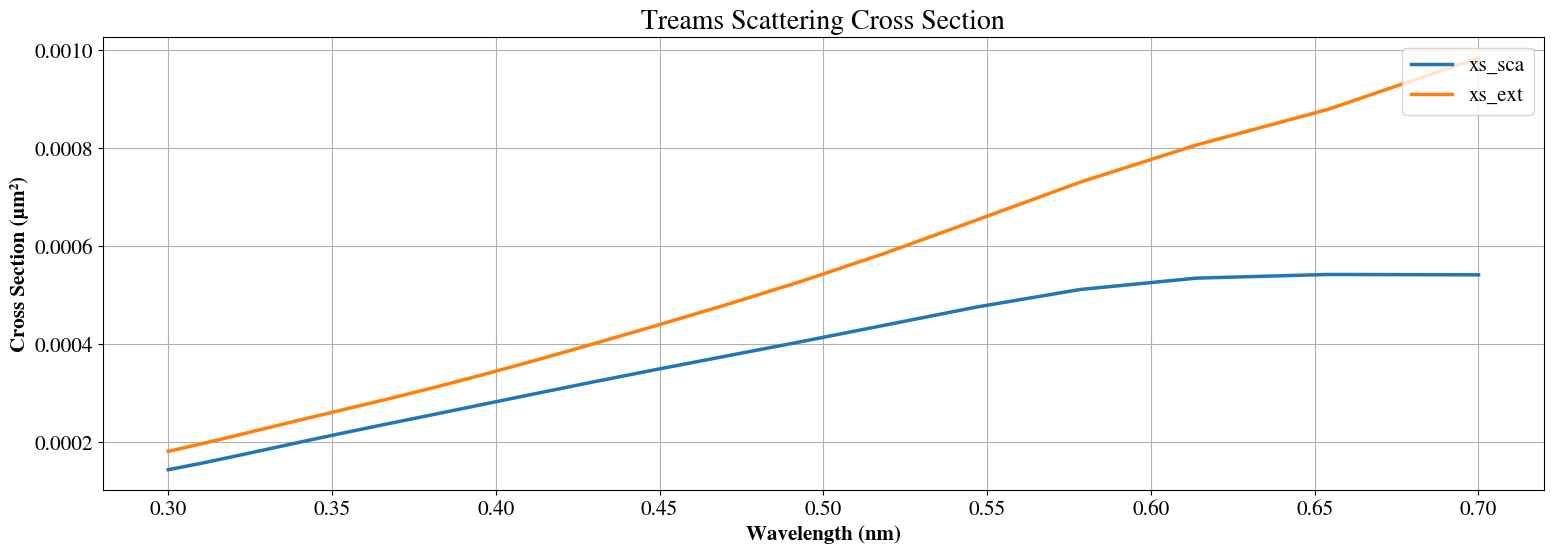

In [ ]:
wl_t = 1e-3 * 2*np.pi/k0s
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

# First plot: Treams scattering cross section
ax.plot(wl_t, np.array(sca)*1e-6, label='xs_sca')
ax.plot(wl_t, np.array(ext)*1e-6, label='xs_ext')  # Uncomment if needed
ax.grid(True)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Cross Section (µm²)')
ax.set_title('Treams Scattering Cross Section')
ax.legend()

plt.tight_layout()
plt.show()

A finer cross section resolution requires either more time or computational power